Copyright 2020 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.


# Gradient boosting

Gradient boosting is another very popular model in modern day data science  and can be viewed as a historical cousin of random forests.

In some ways, gradient boosting is easier to understand than other kinds of boosting, but it probably makes sense to talk about boosting in general first.
Let's go!

### What you will learn

In the sections that follow you will learn about boosting and how boosting can help you reduce error by creating an ensemble of similar models.  We will study the following:

- Boosting
- Gradient boosting

### When to use boosting/gradient boosting

Boosting is a general ensemble technique, like bagging, that can be used with different underlying models. Gradient boosting is an effective an popular form of boosting that can be used for both regression and classification problems. The major limitation of boosting is that it can overfit the data. 

## Boosting

When we talked about random forests, we focused on how to make each one different from the others by randomly sampling data and randomly sampling features.
Each tree in the forest is therefore *independent* of the others, and we can grow the trees in any order or grow them all at once - it doesn't matter.

The key idea behind boosting is to grow each tree *dependent* on the errors of the tree that came before it.
Because each successive tree is somehow based on the errors of the previous tree, each of the trees can be pretty simple, because their errors will be caught by the following trees.
A particularly simple kind of tree often used in boosting is a **decision stump**, so called because it is a tree with three nodes and two branches, as shown in Figure 1 below.

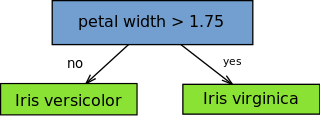

**Figure 1. A decision stump.** Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Decision_stump.svg)

So a boosted model of decision stumps would consist of a series of decision stumps, where each successive one was created dependent on the errors of the previous tree.
The prediction of the boosted model consists of the predictions of each stump in the series, combined into one overall prediction.

Where boosting gets a bit weird and hard to understand is in the details about how dependence on previous errors is defined and how individual predictions are combined, because different boosting algorithms do this in different ways.

One of the most famous boosting algorithms, **AdaBoost**, creates dependence on previous error by giving more "weight" to datapoints that the last tree got wrong, and less "weight" to datapoints that the last tree got right.
This effectively makes the model "focus" on harder datapoints with each successive tree.
All the trees in the sequence make their own predictions, which are weighted by coefficients (a bit like linear regression) to produce an overall prediction.

By the way, although the discussion so far has focused on trees, we should point out that you can do boosting with any model just like you can do bagging with any model.

## Gradient boosting

Gradient boosting is a particularly easy to understand version of boosting if you think about it in terms of regression.
Recall that when we fit a line to some datapoints, the *residuals* are the distances between our line and the datapoints.
Gradient boosting starts with a model that fits a line to a constant (e.g. y=0; see Figure 2-1), and then adds a successive model that **fits to the residuals** of the prior model (Figure 2-2). 
Because residuals can be above or below the line (i.e., positive or negative), Figure 2-2 shows how the gradient boosted model increases its predictions on the left hand side and decreases its predictions on the left hand side.
Each successive model is fit to the residuals of the preceeding model, each time adding more complexity to the model's prediction and bringing it closer to the true function. 
With enough models in the sequence, even a simple decision stump can approximate a function of arbitrary complexity.

You might have noticed in the example below that each successive model seems to have a smaller effect.
This is both because the residuals are getting smaller with each successive model and because there is a shrinkage parameter that is applied to each successive model to make its contributions smaller.

<!-- 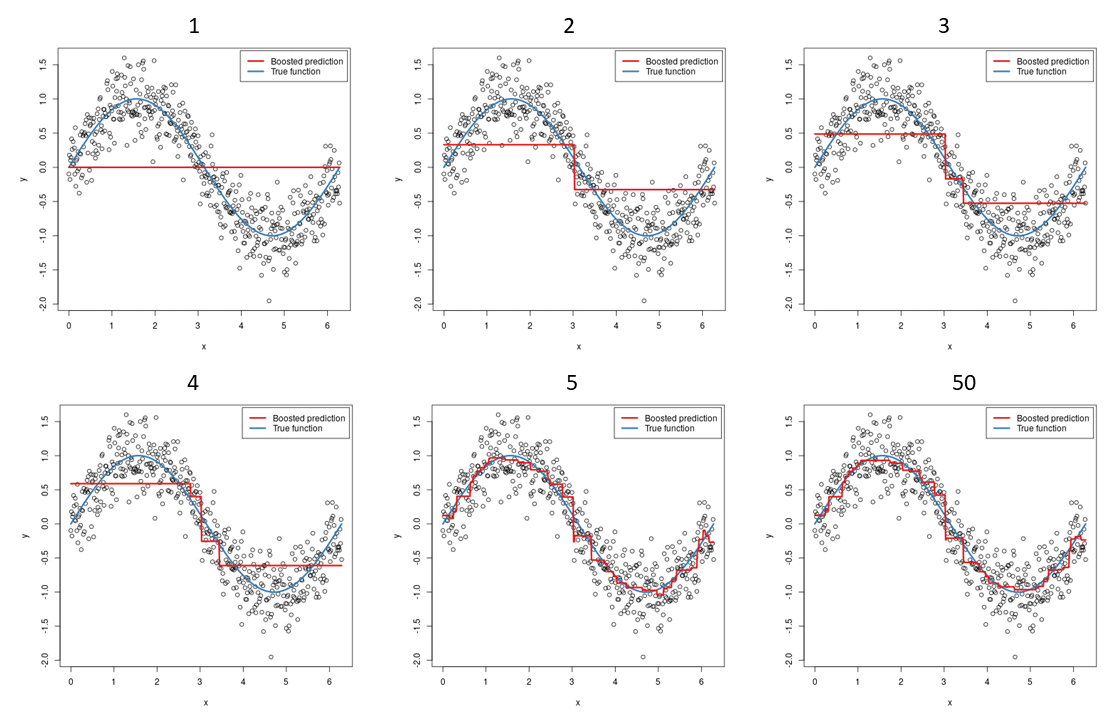 -->
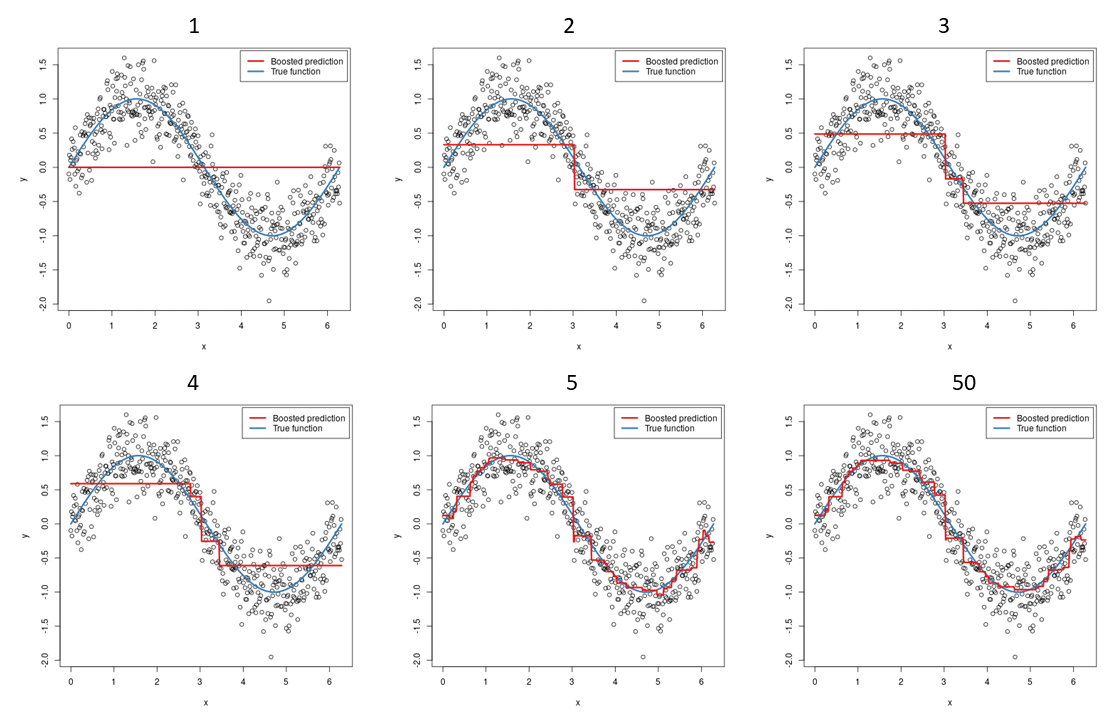
<center><b>Figure 2. Gradient boosting approximating a curve using sequences of 1, 2, 3, 4, 5, and 50 models</b>. Adapted from <a href=https://uc-r.github.io/gbm_regression>University of Cincinati</a></center>

One of the downsides to boosting relative to bagging is that boosting a longer sequence of models will tend to overfit, whereas bagging won't.
This leads naturally to the idea of a **stopping criterion** for boosting, at which point you would stop adding models to the sequence.
One way to determine the stopping criterion is to compare the training performance of the model with its test performance.
**Training performance will always go down with more training, but when the test performance levels off, that's when you want to stop to prevent overfitting.**
An example is shown in Figure 3 below, where the x axis is the number of models in the boosted sequence, and the y-axis is *deviance*, a generalization of sum of squared residuals.

<!-- 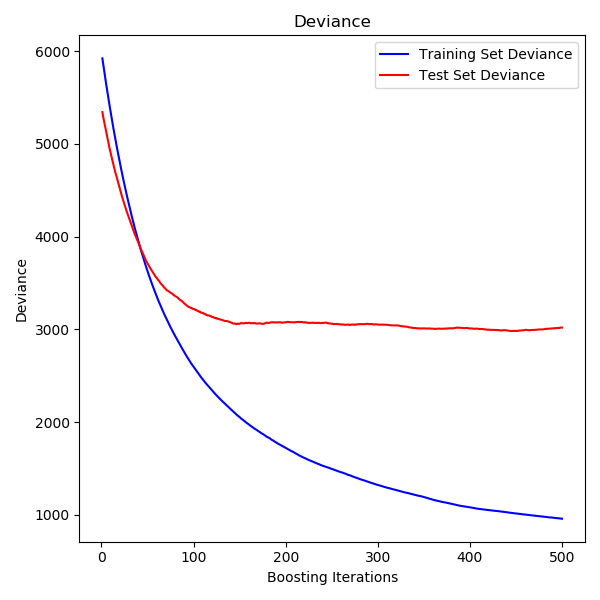 -->
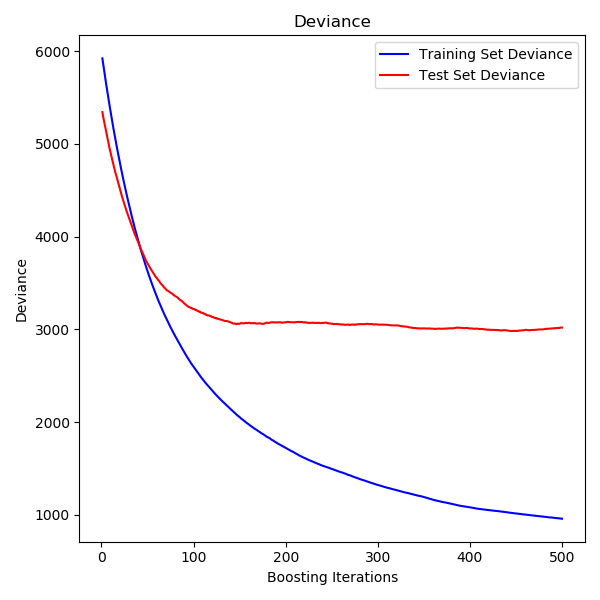
<center><b>Figure 3. Training vs. test deviance as a function of boosting iterations</b>. Source: <a href=https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py>Sklearn</a></center>

## Example: Gradient Boosting Classification

### Load data

Let's look at some data on breakfast cereals, which consists mostly of nutrition information along with some other properties:

| Variable | Type | Description |
|:-------|:-------|:-------|
| name     | Nominal | Name of cereal (an ID)                                                                                                                          |
| mfr      | Nominal | Manufacturer of cereal: (A)merican Home Food Products; (G)eneral Mills; (K)elloggs; (N)abisco; (P)ost; (Q)uaker Oats; (R)alston Purina |
| type     | Nominal | (H)ot or (C)old                                                                                                                        |
| calories | Ratio   | calories per serving                                                                                                                   |
| protein  | Ratio   | grams of protein                                                                                                                       |
| fat      | Ratio   | grams of fat                                                                                                                           |
| sodium   | Ratio   | milligrams of sodium                                                                                                                   |
| fiber    | Ratio   | grams of dietary fiber                                                                                                                 |
| carbo    | Ratio   | grams of complex carbohydrates                                                                                                         |
| sugars   | Ratio   | grams of sugars                                                                                                                        |
| potass   | Ratio   | milligrams of potassium                                                                                                                |
| vitamins | Ordinal | vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended                                            |
| shelf    | Ratio   | display shelf (1, 2, or 3, counting from the floor)                                                                                    |
| weight   | Ratio   | weight in ounces of one serving                                                                                                        |
| cups     | Ratio   | number of cups in one serving                                                                                                          |
| rating   | Ratio   | a rating of the cereals (Possibly from Consumer Reports?)                                                                              |
      
<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from <a href="https://www.kaggle.com/crawford/80-cereals">Kaggle</a>.
</div>
<br>

The goal is to predict manufacturer (`mfr`) using the other properties of the data.

First, the imports `pandas` to work with dataframes:

- `import pandas as pd`

Load the dataframe:

- Create `dataframe` and set it to `with pd do read_csv using` a list containing
    - `"datasets/cereal.csv"`
    - freestyle `index_col="name"` (`name` is an ID)
- `dataframe` (to display)

## Explore data

Let's check the data makes sense with the five figure summary:

- `with dataframe do describe using` 

This looks good, but are there missing values?

The easiest way is to remove them and see if anything changed:

- Set `dataframe` to `with dataframe do dropna using`
- `dataframe`

Comparing against the initial display of the dataframe, we can see we lost 3 rows.
Since it's such a small number, we probably don't need to `describe` the data again.

Let's do a few standard visualizations to better understand these data.

First import `plotly.express` to do plots:

- `import plotly.express as px`

And create a correlation matrix:

- Create `corr` and set to `with dataframe do corr using`

And show a correlation heatmap with row/column labels:

- `with px do imshow using` a list containing
    - `corr`
    - freestyle `x=` followed by `from corr get columns`
    - freestyle `y=` followed by `from corr get columns`

There are some pretty strong positive correlations as well as some negative ones.
These may make sense with types of nutritional information, e.g. carbohydrates and sugar, which you expect to be correlated.

Let's to a scatterplot matrix to see the relationships between these variables in more detail:

- `with px do scatter_matrix using` a list containing
    - `dataframe`
    - freestyle `height=1000`
    - freestyle `width=1000`

Scatterplots with the nominal variables (`mfr` and `type`) aren't that useful, but the numeric scatterplots are interesting.
One in particular that stands out is `rating`, which seems to be negatively related to sugar in a linear way.
That would make sense if the ratings came from Consumer Reports rather than customers!

We could also do histograms to see how the predictor variables are distributed if we wanted to.
However, gradient boosting is such a powerful and flexible method that it is pretty tolerant of data craziness.

Even still, since this is a classification problem, it would be useful to know if our classes are **balanced**, since we know that imbalance means a harder problem.
We could look at balance as a table of frequencies or even percentages, but let's do a plot of frequencies, i.e. a histogram:

- `with px do histogram using` a list containing
    - `dataframe [ ]` with `"mfr"` inside

As we can see, this is an imbalanced classification problem, with Kellogg's and General Mills being the most frequent.
Each of these are about a third of the data, and all the other manufacturers make up the other third.

There's another problem here to: `A` only occurs once, which means it can't be in both training and test sets.
We need to get rid of that row to avoid annoying problems later on.
Let's filter the dataframe to have all the manufacturers *except* `A`.

- Set `dataframe` to `dataframe[ ]` containing
    - `from dataframe get mfr` &ne; `"A"`

## Prepare train/test sets

First we need to separate our predictors (`X`) from our class label (`Y`), putting each into its own dataframe:

- Create `X` and set to `with dataframe do drop using` a list containing
    - freestyle `columns=["mfr"]`
- Create `Y` and set to `dataframe [ ]` containing a list with `"mfr"` inside

However, we're not quite done!

Not all models can handle nominal data, and gradient boosting is one of those models.
We previously saw this with linear models, where we created *dummies* to solve the problem.
We can do the same thing here, but we keep all levels instead of dropping the first one.
Why keep all the levels? 
In linear models, the reference level is absorbed into the intercept of the model, but we don't have that here:

- Set `X` to `with pd get_dummies using` a list containing
    - `X`
- `X` (so you can see what happened)

**Notice we only needed to do this for `X`**.

As you can see, everything is the same except we now have a numeric column for cold cereal.
We only end up with one column here because there were only a few hot cereals to being with, and they all got dropped when we dropped NaNs.

We're now ready to split the data into train/test sets, so import `sklearn.model_selection`:

- `import sklearn.model_selection as model_selection`

And do the actual split:

- Create `splits` and set to `with model_selection do train_test_split` using a list containing
    - `X`
    - `Y`
    - freestyle `stratify=Y`
    - freestyle `random_state=1`
    
**Notes:**
- `stratify=Y` ensures that our train/test sets both contain all class labels, which is important, since some are rare.
- Setting random_state will make our results match each other

## Fit model

Import the necessary libraries for the model:

- `import sklearn.ensemble as ensemble`
- `import numpy as np`

Now we can create the gradient boosting classifier:

- Create variable `gradientBoostingClassifier` and set to `with ensemble create GradientBoostingClassifier using` a list containing
    - freestyle `random_state=1`
    
    
**Note:** The default number of models is 100; there are many other defaults [specified in the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) that can be changed.

Next, `fit` the classifier to the training data:

- `with gradientBoostingClassifier do fit using` a list containing
    - `in list splits get #1` (this is Xtrain)
    - `with np do ravel using` a list containing `in list splits get #3` (this is Ytrain)

And finally, get predictions:

- Create `predictions`
- Set it to `with gradientBoostingClassifier do predict using` a list containing
    - `in list splits get #2` (this is Xtest)

## Evaluate the model

Import `sklearn.metrics` for evaluation:

- `import sklearn.metrics as metrics`

Get the accuracy:

- `with metrics do accuracy_score using` a list containing
    - `in list splits get # 4`  (this is `Ytest`)
    - `predictions`

And get the recall and precision:

- `print with metrics do classification_report using` a list containing
    - `in list splits get # 4`  (this is `Ytest`)
    - `predictions`
    

Notice our test set is relatively small considering how many categories we have, so some categories only have 1 or 2 chances to be right or wrong. 

Let's take a look at the confusion matrix and see if we can better understand what's going on:

- Create variable `cm` and set to `with metrics do confusion_matrix using` using a list containing
    - `in list splits get # 4` (this is Ytest)
    - `predictions`
- `with pd create DataFrame using` a list containing 
    - `cm`
    - `index=gradientBoostingClassifier.classes_`
    - `columns=gradientBoostingClassifier.classes_`

The rows are the true labels, and the columns are the predictions.
As you can see, most errors are to predicting `G` or `K`, which makes sense given their prevalence.
In other words, `G` and `K` are frequent, so they are good guesses when the classifier is uncertain.

## Visualizing

### Feature importance

Because boosting is another ensemble model, we can visualize feature importance in the same way as other ensemble models.

We can create a bar chart of feature importances:

- `with px do bar using` a list containing
    - freestyle `x=` followed by `from X get columns`
    - freestyle `y=` followed by `from gradientBoostingClassifier get feature_importances_`

The most important features are:

- Sodium 
- Rating
- Cups (serving size)
- Carbohydrates
- Fat

This suggests possibly that some manufacturers are "healthier" in their brands than others, but we'd need to look more closely to be sure.

Cold cereal has no weight because it is 1 for all cereals.

### Overfit

As mentioned, we can look at the *deviance* to determine if we have too many models in our boosted model sequence.
The easiest way to do this is add *bagging* back to our model - that's right, we'll be boosting and bagging at the same time!
The reason is that if we add bagging, we can use OOB error as a way of testing overfit on our model.

All we have to do is add the following to our original model, and then rerun the cells back down to this point:

- freestyle `subsample=.5`

**This will bag with half the data.**

To plot the deviance:

- `import plotly.graph_objects as go`

Create an empty figure that we'll add multiple lines to:

- Create `fig` and set to `with go create Figure using`

And add the two lines, one for training deviance and one for testing deviance:

- `with fig do add_scatter using` a list containing
    - freestyle `x=np.arange(0,100)` (this creates a list of 1 to 100 for the x-axes, where 100 is our number of models in the boosted model)
    - freestyle `y=gradientBoostingClassifier.train_score_`
    - freestyle `name="Training Deviance"`

- `with fig do add_scatter using` a list containing
    - freestyle `x=np.arange(0,100)` 
    - freestyle `y=gradientBoostingClassifier.oob_improvement_` 
    - freestyle `name="Testing Deviance"`
    

Zoom in on the testing deviance using the plotly tools (top right corner of plot, hover to reveal).
This plot shows that the model has probably started to overfit early on, since there is not much improvement on the test set after about the 20th model.
If we wanted to, we could go back to the original model and specify `n_estimators=20` to stop the boosting at this point.

<!-- NOTE: Tried to get the non-OOB version of deviance working, but it does not seem to play nice with the classifier version of gradient boosting 
This takes a little bit of effort with the regular gradient boosting model, because we need to calculate the test performance for each stage of the boosted model (every time we add another model, it is a stage, so we have 100 stages).

To save the test performances:

- Create variable `testList` and set to an empty list

testList = []

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Kk9f^1I7w+om?F:,5q)5">testList</variable></variables><block type="variables_set" id="YK;}A5*m0+S[Z4](NjlX" x="7" y="34"><field name="VAR" id="Kk9f^1I7w+om?F:,5q)5">testList</field><value name="VALUE"><block type="lists_create_with" id="Tm7Xtak|?y9FRf}[F5it"><mutation items="0"></mutation></block></value></block></xml>

Now we need to calculate the test performances in a loop and add each test performance to our list:

- `for each item i in list` `with gradientBoostingClassifier do staged_predict using` a list containing `in list splits get #2`
    - Create variable `testScore` and set to `with gradientBoostingClassifier do loss_ using` a list containing
        - `in list splits get # 4`
        - `i`
    - Use an empty freestyle followed by `with testList do append using testScore`

for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)
    


for i in gradientBoostingClassifier.staged_decision_function(splits[1]):
  testScore = gradientBoostingClassifier.loss_(np.ravel(splits[3]),i)
  (testList.append(testScore))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="29|[jgU99ocn(jj$7ECI">i</variable><variable id="rl*Wd%J:ec{~yZp{G@:l">gradientBoostingClassifier</variable><variable id="bgG#s+@:%UJt4*FH!Iq#">testScore</variable><variable id="Kk9f^1I7w+om?F:,5q)5">testList</variable><variable id="{Yt*9=2tTC$JepE9BcRz">splits</variable></variables><block type="controls_forEach" id="dr/g@$dWpO-4]],wBYo)" x="112" y="292"><field name="VAR" id="29|[jgU99ocn(jj$7ECI">i</field><value name="LIST"><block type="varDoMethod" id="d=4`G,8u5hj+dq?pT#Xt"><field name="VAR" id="rl*Wd%J:ec{~yZp{G@:l">gradientBoostingClassifier</field><field name="MEMBER">staged_decision_function</field><data>gradientBoostingClassifier:staged_decision_function</data><value name="INPUT"><block type="lists_create_with" id="ff#tOZL#H%BUh_Av!_ty"><mutation items="1"></mutation><value name="ADD0"><block type="lists_getIndex" id="iK]O5g;M+.TI(ym^2AkI"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="~FNMBoCCjhgLGusk}^|m"><field name="VAR" id="{Yt*9=2tTC$JepE9BcRz">splits</field></block></value><value name="AT"><block type="math_number" id="o{9QSy[19@IFq|Nt[rCp"><field name="NUM">2</field></block></value></block></value></block></value></block></value><statement name="DO"><block type="variables_set" id="dy=e|46jiT@eLm|*l4Su"><field name="VAR" id="bgG#s+@:%UJt4*FH!Iq#">testScore</field><value name="VALUE"><block type="dummyOutputCodeBlock" id="M/paFk^`DwKm}2J3C_a$"><field name="CODE">gradientBoostingClassifier.loss_(splits[3],i)</field></block></value><next><block type="valueNoOutputCodeBlock" id="?DDcPwIF[od#!j[J|CPd"><field name="CODE"></field><value name="INPUT"><block type="varDoMethod" id=")qWkXc]SJ5e/M+JH0GIj"><field name="VAR" id="Kk9f^1I7w+om?F:,5q)5">testList</field><field name="MEMBER">append</field><data>testScore:</data><value name="INPUT"><block type="variables_get" id=")sj-WYP8;XOkKV{I*Noa"><field name="VAR" id="bgG#s+@:%UJt4*FH!Iq#">testScore</field></block></value></block></value></block></next></block></statement></block></xml>

import plotly.graph_objects as go

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="/S5EHzNl)/I50f/-KSZQ">go</variable></variables><block type="importAs" id="WV{jUj%W/=n1;iRGdHoh" x="21" y="-12"><field name="libraryName">plotly.graph_objects</field><field name="libraryAlias" id="/S5EHzNl)/I50f/-KSZQ">go</field></block></xml>

fig = go.Figure(data= (go.Scatter(x=np.arange(0,100), y=testList)))
fig.show()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="FuH.yx^v|kVlL!174TwM">fig</variable><variable id="/S5EHzNl)/I50f/-KSZQ">go</variable></variables><block type="variables_set" id="/0h?*zn[*5v^D?X%MQok" x="75" y="137"><field name="VAR" id="FuH.yx^v|kVlL!174TwM">fig</field><value name="VALUE"><block type="varCreateObject" id="ccYq?D6[iomaxyAzJK/^"><field name="VAR" id="/S5EHzNl)/I50f/-KSZQ">go</field><field name="MEMBER">Figure</field><data>go:Figure</data><value name="INPUT"><block type="lists_create_with" id="ycPfDheyg}%lYK}8FM.Z"><mutation items="1"></mutation><value name="ADD0"><block type="valueOutputCodeBlock" id="Royn=;*Crd(jBx!p9.H@"><field name="CODE">data=</field><value name="INPUT"><block type="varCreateObject" id="4dN=dni.%x:pDs!.AZ{5"><field name="VAR" id="/S5EHzNl)/I50f/-KSZQ">go</field><field name="MEMBER">Scatter</field><data>go:Scatter</data><value name="INPUT"><block type="lists_create_with" id="9NwuXo_4F8YJ|Rv3ef!o"><mutation items="2"></mutation><value name="ADD0"><block type="dummyOutputCodeBlock" id="2Bo.__b@;5.j07_QV8Cd"><field name="CODE">x=np.arrange(0,100)</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="7Qx?|(7nd^r6q!A$_kZ4"><field name="CODE">y=testScore</field></block></value></block></value></block></value></block></value></block></value></block></value></block></xml> 
 -->